# Cas protein and spacer cassette analysis 
### Relating expression to spacer cassette size (hopefully)

Plan:
1. Filter Cas protein results in database to only those that are near a CRISPR casette, and/or filter only high e-value hits or certain protein types. 
2. Get neighbouring casette lengths (copy code from locus number of spacers analysis)
3. Get DNA for *cas* genes and get codons, run through a codon usage analyzer

Will need to download genomes as well.

In [1]:
import requests
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import mlab
import seaborn as sns
import pandas as pd
from scipy import stats
from tqdm import tqdm
from Bio import SeqIO

sns.set_palette("husl")

In [2]:
#Url of the phageParser API
apiurl = 'https://phageparser.herokuapp.com'
#Get the initial page for listing of accessible objects and get url for organisms and casproteins
url_json=requests.get(apiurl).json()
organisms_url = url_json['organisms']
cas_proteins_url = url_json['casproteins']
organism_cas_url = url_json['organismcas']
loci_url = url_json['loci']

In [3]:
#Iterate through each page and merge the json response into a dictionary for cas proteins
cas_protein_dict = {}
r=requests.get(cas_proteins_url)
last_page = r.json()['meta']['total_pages']
for page in range(1,last_page+1):
    url = cas_proteins_url+'?page={}'.format(page)
    payload = requests.get(url).json()
    cas_protein_objs = payload['cas_proteins']
    for cas_protein_obj in cas_protein_objs:
        cas_protein_dict[cas_protein_obj['id']] = cas_protein_obj

In [4]:
#Iterate through each page and merge the json response into a dictionary for organisms
organism_dict = {}
r=requests.get(organisms_url)
last_page = r.json()['meta']['total_pages']
for page in tqdm(range(1,last_page+1)):
    url = organisms_url+'?page={}&include[]=cas_proteins&include[]=loci.spacers'.format(page)
    payload = requests.get(url).json()
    organism_objs = payload['organisms']
    for organism_obj in organism_objs:
        organism_dict[organism_obj['id']] = organism_obj

In [ ]:
# Iterate through each page and merge the json response into a dictionary for organism_cas
# this takes a long time
organism_cas_dict = {}
r = requests.get(organism_cas_url)
last_page = r.json()['meta']['total_pages']
for page in tqdm(range(1, last_page+1)):
    url = organism_cas_url+'?page={}'.format(page)
    payload = requests.get(url).json()
    organism_cas_objs = payload['organism_cas_proteins']
    for organism_cas_obj in organism_cas_objs:
        organism_cas_dict[organism_cas_obj['id']] = organism_cas_obj

 37%|███▋      | 166/446 [04:20<11:09,  2.39s/it]

In [5]:
# Iterate through each page and merge the json response into a dictionary for loci
loci_dict = {}
r = requests.get(loci_url)
last_page = r.json()['meta']['total_pages']
for page in tqdm(range(1, last_page+1)):
    url = loci_url+'?page={}&include[]=spacers'.format(page)
    payload = requests.get(url).json()
    loci_objs = payload['locus']
    for locus_obj in loci_objs:
        loci_dict[locus_obj['id']] = locus_obj

100%|██████████| 18/18 [01:21<00:00,  4.08s/it]


In [ ]:
# create dictionary with the info and positions of all cas proteins in each organism
# note: this may be longer than the list of cas proteins in the organism dict, since some proteins may appear twice
from collections import defaultdict

organism_to_cas_dict = defaultdict(dict)
for i, values in organism_cas_dict.items():
    organism_to_cas_dict[values['organism']][i] = values

### Retain only cas proteins near a cassette

In [ ]:
distance_from_locus = 50000 # base pairs, look up what would be a good value
# a cas9 sequence that I randomly found is like 9000 bp, so 50 000 seems like a reasonable cutoff.
# also the cutoff doesn't really matter - the numbers are the same whether the cutoff is 50 000 or 500 000

In [ ]:
organism_names = []
loci = []
cas_genes = []
cas_near_cassette_dict = defaultdict(dict)

for organism_id in organism_dict.keys():

    # search_window[0] must be less than search_window[1]

    search_windows = {}
    for locus in organism_dict[organism_id]['loci']:
        # check that start is less than end
        if not locus['genomic_start'] < locus['genomic_end']:
            print('end is less than start')
        search_windows[locus['id']] = {'window': [locus['genomic_start'] - 1000, locus['genomic_end'] + 1000]}
    
    for locus_id, windows in search_windows.items():
        for cas_id, values in organism_to_cas_dict[organism_id].items():
            #print(values['genomic_start'])
            if values['genomic_start'] > windows['window'][0] and values['genomic_end'] < windows['window'][1]:
                #print(organism_id, organism_dict[organism_id]['accession'], organism_dict[organism_id]['name'], locus_id)
                organism_names.append("%s %s\n" %(organism_dict[organism_id]['accession'], organism_dict[organism_id]['name']))
                loci.append(locus_id)
                cas_genes.append(values['casprotein'])
                cas_near_cassette_dict[organism_id][cas_id] = values
                cas_near_cassette_dict[organism_id][cas_id]['locus'] = locus_id # also add locus id
                

In [ ]:
print(len(set(organism_names)))
print(len(set(loci)))
print(len(set(cas_genes)))
print(len(cas_genes))
print(len(cas_protein_dict))

In [10]:
# save list of organisms that have cas proteins near casettes
organism_names = list(set(organism_names))

with open('organism_names.txt', 'w') as file:
    for line in organism_names:
        file.write(line)

In [ ]:
# create accession list
!cat organism_names.txt | cut -d" " -f1 > organism_accessions.txt

# download all organism genomes that were found to be hits
#!cat organism_accessions.txt | python ../parserscripts/acc2gb.py your@email.com nuccore fasta_cds_na > cas_bacteria.dat

Need CDS regions for the AnaCoDa thing, so to download CDS fasta I think use `fasta_cds_na` (nucleotides for cds) or `fasta_cds_aa` (translated amino acids for cds). 

In [5]:
# split fasta file for all organisms into files separated by organism - only run once

current_accession = 0
past_accession = 0

for record in tqdm(SeqIO.parse("cas_bacteria.dat", "fasta")):
    header = record.id
    accession = header.rsplit('|')[1].rsplit('.')[0]
    current_accession = accession
    if current_accession != past_accession: # start a new file
        with open("%s.fasta" %accession, "w") as output_handle:
            SeqIO.write(record, output_handle, "fasta")
    else:
        with open("%s.fasta" %accession, "a") as output_handle:
            SeqIO.write(record, output_handle, "fasta")
    past_accession = current_accession

1200252it [01:45, 11389.05it/s]


In [ ]:
# link cas genes to their position in the cds list
for record in tqdm(SeqIO.parse("cas_bacteria.dat", "fasta")):
    header = record.id
    accession = header.rsplit('|')[1].rsplit('.')[0]
    org_id = accession_to_organism_id[accession]
    cds_number = int(header.split('_')[-1])
    description = record.description
    current_accession = accession

    for key, value in cas_near_cassette_dict[org_id].items():
        try: 
            start = description.index(str(value['genomic_start']))
            end = description.index(str(value['genomic_end']))
            cas_near_cassette_dict[org_id][key]['cds_number'] = cds_number
            #print(org_id)
        except:
            print(value)
            pass

In [ ]:
# create dictionary linking accession numbers and organism IDs
accession_to_organism_id = {}
for key, values in organism_dict.items():
    accession_to_organism_id[values['accession']] = key

## Analysis plan

1. Get expression model data using the [AnaCoDa R package](https://rdrr.io/cran/AnaCoDa/f/inst/doc/anacoda.Rmd), save file as `accession-expression.csv`
2. Load expression data using pandas
3. Get cas gene ids: 
```
cas_gene_positions = []
for val in cas_near_cassette_dict[accession_to_organism_id['NZ_CP015184']].values():
    cas_gene_positions.append(val['cds_number'])
```
4. The gene ids-1 are the index for the expression data frame (b/c zero indexing) **expression levels**
5. Get associated locus size: 
```
associated_loci = []
loci_lengths = []
for val in cas_near_cassette_dict[accession_to_organism_id['NZ_CP015184']].values():
    associated_loci.append(val['locus'])
    loci_lengths.append(len(loci_dict[val['locus']]['spacers'])
```
6. Multiple genes may be associated with the same locus, but now `cas_gene_positions` and `associated_loci` should be the same length to match them up (locus indices may be repeated). **locus lengths**

Annddd.... done! Make a sweet plot

Removed genome NZ_CP009177 from organism accession list - causing errors

In [126]:
# get list of which organisms have been analyzed
!ls *expression.csv | cut -d"-" -f1 > done_accessions.txt 

In [ ]:
accessions_done = pd.read_csv("done_accessions.txt", names = ['acc'])

expression_list = []
locus_size_list = []
for accession in accessions_done.acc:

    expression = pd.read_csv("%s-expression.csv" %accession)
    #print(np.mean(expression.PHI))
    names_split = expression["names"].str.rsplit("_", n=1, expand = True)  # split names column from the right to isolate cds position
    expression["protein_position"] = names_split.iloc[:,-1] # create column for cds position
    expression["protein_position"] = pd.to_numeric(expression["protein_position"]) # convert to numeric
    
    cas_gene_positions = []
    for val in cas_near_cassette_dict[accession_to_organism_id[accession]].values():
        cas_gene_positions.append(val['cds_number'])
        
    associated_loci = []
    loci_lengths = []
    for val in cas_near_cassette_dict[accession_to_organism_id[accession]].values():
        associated_loci.append(val['locus'])
        loci_lengths.append(len(loci_dict[val['locus']]['spacers']))
        
    # get expression level for the cas genes in the organism (normalize by mean expression level)
    expression_vals = expression.loc[expression["protein_position"].isin(cas_gene_positions)].PHI / np.mean(expression.PHI)
    if expression_vals.empty:
        print(expression_vals)
        expression_vals_empty = expression
        cas_gene_positions_empty = cas_gene_positions
    
    expression_list.append(list(expression_vals))
    locus_size_list.append(loci_lengths)
    

In [128]:
len(accessions_done)

46

In [124]:
val

{'id': 12543,
 'organism': 2299,
 'casprotein': 20,
 'genomic_start': 3598531,
 'genomic_end': 3598824,
 'evalue': 2.1e-38,
 'locus': 2278}

In [113]:
# flatten lists

expression_list_flat = [item for sublist in expression_list for item in sublist] 
locus_size_list_flat = [item for sublist in locus_size_list for item in sublist] 


In [114]:
from scipy.optimize import curve_fit

def line(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

A,B = curve_fit(line, locus_size_list_flat, expression_list_flat)[0] # your data x, y to fit

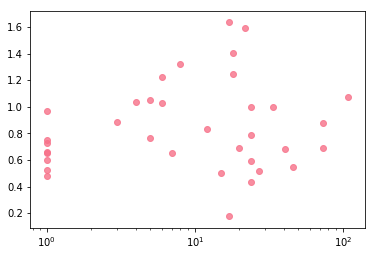

In [119]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.scatter(locus_size_list_flat, expression_list_flat, alpha = 0.8)
#ax.plot(locus_size_list_flat, np.array(locus_size_list_flat)*A+B)

In [169]:
locus_size_list

[[3], [8], [15], [1, 1]]

In [159]:
associated_loci

[3186, 3186]

In [158]:
loci_lengths

[1, 1]

From their paper, "the units of phi are proteins per time, and time is scaled such that the the prior for phi satisfies E(phi) = 1." I don't really know what that means, but it hopefully means that results are comparable across genomes?

(array([267., 615., 530., 310., 171.,  96.,  52.,  32.,  17.,  16.,  15.,
          5.,   8.,  12.,   6.,   4.,   1.,   1.,   1.,   1.]),
 array([0.19174138, 0.46599141, 0.74024145, 1.01449148, 1.28874152,
        1.56299155, 1.83724159, 2.11149162, 2.38574166, 2.65999169,
        2.93424173, 3.20849176, 3.4827418 , 3.75699183, 4.03124187,
        4.3054919 , 4.57974194, 4.85399197, 5.12824201, 5.40249204,
        5.67674208]),
 <a list of 20 Patch objects>)

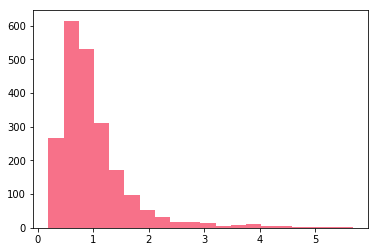

In [153]:
plt.hist(expression_list[3].PHI, bins = 20)

In [224]:
organism_id = 25

search_windows = {}
for locus in organism_dict[organism_id]['loci']:
    # check that start is less than end
    if not locus['genomic_start'] < locus['genomic_end']:
        print('end is less than start')
    search_windows[locus['id']] = {'window': [locus['genomic_start'] - 1000, locus['genomic_end'] + 1000]}



In [235]:
plot_regions = []
for loci in organism_dict[organism_id]['loci']:
    #print(loci['genomic_start'], loci['genomic_end'])
    plot_regions.append({'position': [loci['genomic_start'], loci['genomic_end']], 'label': 'casette'})
    
for locus_id, windows in search_windows.items():
    for cas_id, values in organism_to_cas_dict[organism_id].items():
        #print(values['genomic_start'])
        if values['genomic_start'] > windows['window'][0] and values['genomic_end'] < windows['window'][1]:
            #print(str(organism_id) + 'yes')
            plot_regions.append({'position': [values['genomic_start'], values['genomic_end']], 
                                 'label': cas_protein_dict[values['casprotein']]['gene']})
            print(values)
    

{'id': 100592, 'organism': 25, 'casprotein': 305, 'genomic_start': 108876, 'genomic_end': 109115, 'evalue': 5.3e-09}
{'id': 100593, 'organism': 25, 'casprotein': 140, 'genomic_start': 109222, 'genomic_end': 109647, 'evalue': 2.7e-74}
{'id': 100593, 'organism': 25, 'casprotein': 140, 'genomic_start': 109222, 'genomic_end': 109647, 'evalue': 2.7e-74}


In [226]:
plot_regions

[{'position': [120875, 121147], 'label': 'casette'},
 {'position': [109850, 110064], 'label': 'casette'},
 {'position': [115342, 115737], 'label': 'casette'},
 {'position': [110210, 110850], 'label': 'casette'},
 {'position': [108876, 109115], 'label': 'cse2gr11'},
 {'position': [109222, 109647], 'label': 'cas7'},
 {'position': [109222, 109647], 'label': 'cas7'}]

In the NCBI database for this organism, the closest CDS regions for the cas genes are:

```
complement(108876..109115)
                     /locus_tag="GZL_RS47195"
                     /inference="COORDINATES: similar to AA
                     sequence:RefSeq:WP_006272258.1"
                     /note="Derived by automated computational analysis using
                     gene prediction method: Protein Homology."
                     /codon_start=1
                     /transl_table=11
                     /product="hypothetical protein"
                     /protein_id="WP_078876378.1"
                     /translation="MVLDPFGGTGTTAAAAKVLGRVGISVDLSPAYTRTAASPSPTPS
                     ANGVARPAGEWGSSSPQSSNWSTLWWMARLRLTLS"
```

```
109222..109647
                     /locus_tag="GZL_RS43525"
                     /old_locus_tag="GZL_p00118"
                     /inference="COORDINATES: ab initio prediction:GeneMarkS+"
                     /note="Derived by automated computational analysis using
                     gene prediction method: GeneMarkS+."
                     /codon_start=1
                     /transl_table=11
                     /product="hypothetical protein"
                     /protein_id="WP_040108171.1"
                     /translation="MHRDVTARPWAREREQARAWQAVVAARAEAAAARPEENVDVSVV
                     APAPVVLPAPRPSAAATEPELEDADDDQDLVLEDLTREQVLGWRDRAATDHQIVHDHI
                     ARYGEHSAQRLFTRAFVATVQRLSHLGHLDLGYTPWRQA"
```

So the good news is, the windows that the database outputs correspond to true CDS regions in NCBI, and we can get the translation from NCBI if necessary. Perhaps we should download the genbank files? or will it work to translate them ourselves?

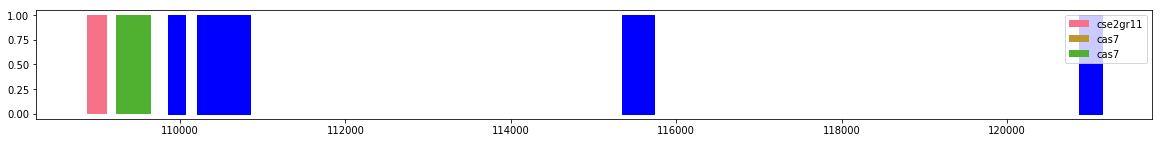

In [227]:
fig, ax = plt.subplots(figsize = (20,2))

# get max range needed
min_value = 10**10
max_value = 0
for region in plot_regions:
    if region['position'][0] < min_value:
        min_value = region['position'][0]
    if region['position'][1] > max_value:
        max_value = region['position'][1]
     
    #if region['label'] == 'casette':
    #    colour = 'b'
    #else:
    #    colour = 'g'
    if region['label'] == 'casette':
        ax.fill_between([region['position'][0], region['position'][1]],0,1, color = 'b')
    else:
        ax.fill_between([region['position'][0], region['position'][1]],0,1, label = region['label'])

#ax.set_xlim(1893000, 1910000)
#ax.set_xlim(748000, 753000)
ax.legend(loc='best')
    

In [228]:
# download a bacterial genome

accession = organism_dict[organism_id]['accession']
print(accession)
print(organism_dict[organism_id]['name'])
!echo "$accession" | python ../parserscripts/acc2gb.py madeleine.bonsma@gmail.com nuccore fasta > "$accession".dat

NZ_CP003988
Streptomyces sp. 769
Fetching 1 entries from GenBank: NZ_CP003988


In [229]:
from Bio import SeqIO
for record in SeqIO.parse("%s.dat" %accession, "fasta"):
    genome = record.seq

In [ ]:
from Bio import Seq
print(Seq.transcribe(Seq.reverse_complement(genome[109222:109647])))
print(Seq.translate((genome[109222:109647])))

In [233]:
len(genome[109222:109647])/3

141.66666666666666

In [230]:
print(genome[109222:109647])

TGCACCGGGACGTGACGGCCAGGCCGTGGGCGCGCGAGCGCGAACAGGCCCGCGCCTGGCAGGCGGTCGTCGCAGCGCGCGCCGAAGCCGCGGCCGCGCGGCCCGAGGAGAACGTCGACGTCTCGGTCGTTGCGCCGGCACCGGTCGTCTTGCCCGCGCCCCGCCCGTCCGCCGCCGCTACGGAGCCGGAGCTCGAGGACGCCGACGACGACCAGGATCTGGTCCTCGAGGACTTGACGCGCGAGCAGGTGCTGGGCTGGCGCGACCGCGCTGCCACCGATCACCAGATCGTCCACGACCACATCGCCCGGTACGGCGAGCACTCGGCGCAGAGGCTGTTCACCCGGGCATTCGTCGCGACCGTGCAGCGCCTGTCCCACCTCGGGCACCTCGACCTTGGCTACACCCCATGGAGGCAGGCGTGA


Current issue: these don't look like obvious proteins in the sense of having a start codon at one end and a stop at the other. Translate all ORFs? How to identify which are the actual codons? Maybe the hmmer documentation has some info about this.